# basic train demo1



### general import

In [1]:
import sys
sys.path.append('../')
from armoInclude import *
from armoTrain import basicModel

### get the data

In [2]:
def GenHarmonicData( numSignals: int, numSamples: int, samplingFreq: float, maxFreq: float, σ: float ) -> Tuple[torch.Tensor, torch.Tensor]:
    
    π = np.pi #<! Constant Pi

    vT   = torch.linspace(0, numSamples - 1, numSamples) / samplingFreq #<! Time samples
    vF   = maxFreq * torch.rand(numSignals)                             #<! Frequency per signal
    vPhi = 2 * π * torch.rand(numSignals)                               #<! Phase per signal
    
    # x_i(t) = sin(2π f_i t + φ_i) + n_i(t)
    mX = torch.sin(2 * π * vF[:, None] @ vT[None, :] + vPhi[:, None])       ## @ is matrix multiplication in PyTorch
    mX = mX + σ * torch.randn(mX.shape) #<! Add noise

    return mX, vF


In [3]:
numSignalsTrain = 1_000
numSignalsVal   = 100
numSignalsTest  = 100
numSamples      =  500 #<! Samples in Signal
samplingFreq    = 100.0 #<! [Hz]
maxFreq         = 10.0  #<! [Hz]
σ               = 0.1 #<! Noise Std

mXTrain, vYTrain    = GenHarmonicData(numSignalsTrain, numSamples, samplingFreq, maxFreq, σ) #<! Train Data
mXVal, vYVal        = GenHarmonicData(numSignalsVal, numSamples, samplingFreq, maxFreq, σ)   #<! Validation Data
mXTest, vYTest      = GenHarmonicData(numSignalsTest, numSamples, samplingFreq, maxFreq, σ)  #<! Test Data



### data preprocess

### Transforms

In [4]:
dsTrain = torch.utils.data.TensorDataset(mXTrain.view(numSignalsTrain, 1, -1), vYTrain) 
dsVal   = torch.utils.data.TensorDataset(mXVal.view(numSignalsVal, 1, -1), vYVal)
dsTest  = torch.utils.data.TensorDataset(mXTest.view(numSignalsTest, 1, -1), vYTest)

### data loaders

In [5]:
batchSize   = 256
numWork     = 2 #<! Number of workers
nEpochs     = 20

dlTrain  = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize, num_workers = numWork, persistent_workers = True)
dlVal   = torch.utils.data.DataLoader(dsVal, shuffle = False, batch_size = 2 * batchSize, num_workers = numWork, persistent_workers = True)
dlTest   = torch.utils.data.DataLoader(dsTest, shuffle = False, batch_size = 2 * batchSize, num_workers = numWork, persistent_workers = True)

In [6]:
# Iterate on the Loader
tX, vY = next(iter(dlTrain)) #<! PyTorch Tensors
print(f'The batch features dimensions: {tX.shape}')
print(f'The batch labels dimensions: {vY.shape}')

The batch features dimensions: torch.Size([256, 1, 500])
The batch labels dimensions: torch.Size([256])


### layers to model

In [7]:
def myModel( ) -> nn.Module:
    
    oModel = nn.Sequential(
        nn.Identity(),
        
        nn.Conv1d(in_channels = 1,   out_channels = 32,  kernel_size = 11), nn.MaxPool1d(kernel_size = 2), nn.ReLU(),
        nn.Conv1d(in_channels = 32,  out_channels = 64,  kernel_size = 11), nn.MaxPool1d(kernel_size = 2), nn.ReLU(),
        nn.Conv1d(in_channels = 64,  out_channels = 128, kernel_size = 11), nn.MaxPool1d(kernel_size = 2), nn.ReLU(),
        nn.Conv1d(in_channels = 128, out_channels = 256, kernel_size = 11), nn.MaxPool1d(kernel_size = 2), nn.ReLU(),
                
        nn.AdaptiveAvgPool1d(output_size = 1),
        nn.Flatten          (),
        nn.Linear           (in_features = 256, out_features = 1),
        nn.Flatten          (start_dim = 0),
        )

    return oModel

In [8]:
oModel = myModel()

### summary

In [9]:
torchinfo.summary(oModel,input_size=tX.shape ,  device = 'cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [256]                     --
├─Identity: 1-1                          [256, 1, 500]             --
├─Conv1d: 1-2                            [256, 32, 490]            384
├─MaxPool1d: 1-3                         [256, 32, 245]            --
├─ReLU: 1-4                              [256, 32, 245]            --
├─Conv1d: 1-5                            [256, 64, 235]            22,592
├─MaxPool1d: 1-6                         [256, 64, 117]            --
├─ReLU: 1-7                              [256, 64, 117]            --
├─Conv1d: 1-8                            [256, 128, 107]           90,240
├─MaxPool1d: 1-9                         [256, 128, 53]            --
├─ReLU: 1-10                             [256, 128, 53]            --
├─Conv1d: 1-11                           [256, 256, 43]            360,704
├─MaxPool1d: 1-12                        [256, 256, 21]            --
├

### target HW

In [10]:
runDevice = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #<! The 1st CUDA device
oModel = oModel.to(runDevice)

### loss

In [11]:
hL = nn.MSELoss()
hL = hL.to(runDevice)


### score

In [12]:
hS = R2Score(num_outputs = 1)
hS = hS.to(runDevice)


### optimizer

In [13]:
oOpt = torch.optim.AdamW(oModel.parameters(), lr = 1e-4, betas = (0.9, 0.99), weight_decay = 1e-5)

### scheduler

In [14]:
oSch = torch.optim.lr_scheduler.OneCycleLR(oOpt, max_lr = 5e-4, total_steps = nEpochs)


### train

In [15]:
nEpochs = 10
# myTrain = basicModel(CheckpointFile='BestModel.pt')
myTrain = basicModel()
trained = myTrain.TrainModel(oModel, dlTrain, dlVal, oOpt, nEpochs, hL, hS, oSch = oSch)

Epoch    1 / 10 | Train Loss: 33.006 | Val Loss: 31.534 | Train Score: -3.037 | Val Score: -3.072 | Epoch Time:  1.73 |
Epoch    2 / 10 | Train Loss: 32.273 | Val Loss: 30.256 | Train Score: -2.948 | Val Score: -2.907 | Epoch Time:  1.58 |
Epoch    3 / 10 | Train Loss: 30.070 | Val Loss: 25.811 | Train Score: -2.701 | Val Score: -2.333 | Epoch Time:  1.30 |
Epoch    4 / 10 | Train Loss: 21.652 | Val Loss:  9.098 | Train Score: -1.668 | Val Score: -0.175 | Epoch Time:  1.40 |
Epoch    5 / 10 | Train Loss:  8.434 | Val Loss:  7.907 | Train Score: -0.034 | Val Score: -0.021 | Epoch Time:  1.19 |
Epoch    6 / 10 | Train Loss:  5.045 | Val Loss:  4.861 | Train Score:  0.378 | Val Score:  0.372 | Epoch Time:  1.09 |
Epoch    7 / 10 | Train Loss:  3.944 | Val Loss:  1.363 | Train Score:  0.517 | Val Score:  0.824 | Epoch Time:  1.42 |
Epoch    8 / 10 | Train Loss:  1.733 | Val Loss:  1.021 | Train Score:  0.788 | Val Score:  0.868 | Epoch Time:  1.26 |
Epoch    9 / 10 | Train Loss:  0.802 | V

### train graph

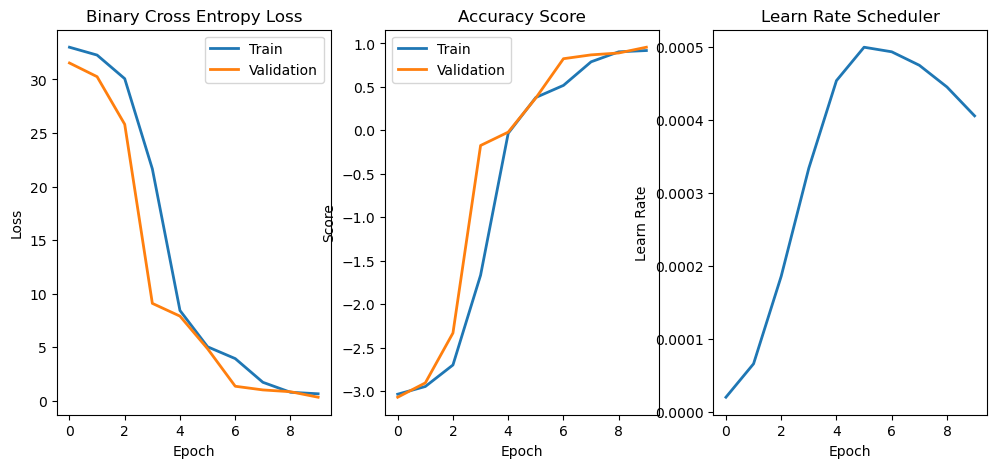

In [16]:
myTrain.plotTrainResults()

## Test after train

In [17]:
myTrain.evaluate_test_data(testData = dlTest ,loss_fn=hL)

Test Loss: 0.402001291513443


0.402001291513443

## inference

In [18]:
test_x_data = mXTest.view(numSignalsTest, 1, -1)
eval_result = myTrain.inference(test_x_data)
print(f"test_x_data[1] = {test_x_data[1] }")      
print(f"eval_result[1] = {eval_result[1] }")      

test_x_data[1] = tensor([[ 1.4371e-01,  3.5111e-01,  1.1869e-01, -3.1413e-01, -3.1478e-01,
         -4.3045e-01, -7.8414e-01, -6.8507e-01, -8.9047e-01, -1.1208e+00,
         -8.4961e-01, -9.0280e-01, -8.3635e-01, -8.3353e-01, -6.2096e-01,
         -7.0435e-01, -4.3796e-01, -1.9775e-01, -2.7062e-01,  1.2534e-01,
          2.5696e-01,  4.4664e-01,  5.2078e-01,  5.3343e-01,  9.9656e-01,
          9.3184e-01,  9.6501e-01,  8.9791e-01,  9.9010e-01,  1.0338e+00,
          8.5075e-01,  5.9509e-01,  5.5645e-01,  4.2926e-01,  1.2612e-01,
          1.7579e-01, -2.0537e-01, -1.9620e-01, -5.7402e-01, -7.1352e-01,
         -7.2135e-01, -8.8277e-01, -8.5816e-01, -1.0018e+00, -1.0573e+00,
         -9.5651e-01, -1.0592e+00, -7.6258e-01, -6.3645e-01, -6.1010e-01,
         -3.2431e-01, -3.7336e-01,  7.0165e-04,  1.7302e-01,  2.7512e-01,
          4.5022e-01,  6.8937e-01,  9.2847e-01,  8.0008e-01,  1.0143e+00,
          8.9333e-01,  1.2493e+00,  7.9179e-01,  8.2739e-01,  7.8015e-01,
          6.0455e-01,